In [3]:
import pandas as pd
import sqlite3
import os

# 1. LE DECIMOS A PYTHON DÓNDE ESTÁN LOS ARCHIVOS
ruta_carpeta = r'C:\Users\GNYAO\OneDrive - Bayer\Desktop\Data Analyst\proyecto final hack'
os.chdir(ruta_carpeta)

try:
    # 2. Cargar la Fuente 1 (CSV)
    df_csv = pd.read_csv('clientes_crm.csv')
    print("✅ CSV cargado.")

    # 3. Cargar la Fuente 2 (SQL)
    conn = sqlite3.connect('marketing_data.db')
    df_sql = pd.read_sql_query("SELECT * FROM resultados_campaña", conn)
    conn.close()
    print("✅ SQL cargado.")

    # 4. Unir ambos DataFrames
    df_final = pd.concat([df_csv, df_sql], axis=1)
    print("Unión completada.")
    
    # Mostrar el resultado
    display(df_final.head())

except FileNotFoundError:
    print("Error! No encuentro los archivos.")

✅ CSV cargado.
✅ SQL cargado.
Unión completada.


,age,job,marital,education,housing,loan,emp.var.rate,cons.price.idx,euribor3m,y
0,56,housemaid,married,basic.4y,no,no,1.1,93.994,4.857,no
1,57,services,married,high.school,no,no,1.1,93.994,4.857,no
2,37,services,married,high.school,yes,no,1.1,93.994,4.857,no
3,40,admin.,married,basic.6y,no,no,1.1,93.994,4.857,no
4,56,services,married,high.school,no,yes,1.1,93.994,4.857,no


## LIMPIEZA

In [4]:
# --- 1. LIMPIEZA DE NOMBRES ---
# Cambiamos los puntos por guiones bajos
df_final.columns = [c.replace('.', '_') for c in df_final.columns]

# --- 2. TRANSFORMACIÓN DE LA VARIABLE OBJETIVO ---
# Pasamos 'yes'/'no' a 1/0 para poder hacer cálculos matemáticos
df_final['y'] = df_final['y'].map({'yes': 1, 'no': 0})

# --- 3. FORMATOS Y GESTIÓN DE NULOS ---
# Ponemos profesiones en mayúscula y'unknown'
df_final['job'] = df_final['job'].str.capitalize()
df_final['education'] = df_final['education'].str.capitalize()

# En lugar de "No Consta", normalizamos el "unknown" a "Unknown"
df_final = df_final.replace('unknown', 'Unknown')


print("Limpieza completada. Columnas actuales:", df_final.columns.tolist())
df_final.head()

Limpieza completada. Columnas actuales: ['age', 'job', 'marital', 'education', 'housing', 'loan', 'emp_var_rate', 'cons_price_idx', 'euribor3m', 'y']


,age,job,marital,education,housing,loan,emp_var_rate,cons_price_idx,euribor3m,y
0,56,Housemaid,married,Basic.4y,no,no,1.1,93.994,4.857,0
1,57,Services,married,High.school,no,no,1.1,93.994,4.857,0
2,37,Services,married,High.school,yes,no,1.1,93.994,4.857,0
3,40,Admin.,married,Basic.6y,no,no,1.1,93.994,4.857,0
4,56,Services,married,High.school,no,yes,1.1,93.994,4.857,0


## TRANSFORMACION DATOS

In [5]:
# --- 1. SEGMENTACIÓN POR EDAD ---
df_final['age_group'] = pd.cut(df_final['age'], 
                                bins=[0, 30, 45, 60, 100], 
                                labels=['Young', 'Adult', 'Senior', 'Retired'])


# --- 2. SIMPLIFICACIÓN DEL NIVEL EDUCATIVO. creamos diccionario y aplicamos a la columna education y creamos education level, dejamos la otra por el moemnto tambien ---
# Usamos las claves tal cual aparecen en el dataset original antes de capitalizar 
edu_map = {
    'Basic.4y': 'Basic', 'Basic.6y': 'Basic', 'Basic.9y': 'Basic',
    'High.school': 'High School', 'Professional.course': 'Professional',
    'University.degree': 'University', 'Illiterate': 'Illiterate',
    'Unknown': 'Unknown'
}

# Aplicamos el mapa asegurándonos de que comparamos minúsculas
df_final['education_level'] = df_final['education'].str.lower().map({k.lower(): v for k, v in edu_map.items()})

# --- 3. PERFIL DE RIESGO ---
def define_risk(row):
    if row['housing'] == 'yes' and row['loan'] == 'no':
        return 'Low'
    elif row['loan'] == 'yes':
        return 'High'
    else:
        return 'Medium'

df_final['risk_profile'] = df_final.apply(define_risk, axis=1)

# --- 4. ESTADO DEL EURIBOR (Buscando el nombre real) ---
# Esto evita el error anterior buscando la palabra 'euribor'
col_euribor = [c for c in df_final.columns if 'euribor' in c][0]
df_final['euribor_status'] = pd.qcut(df_final[col_euribor], q=3, labels=['Low', 'Medium', 'High'])

# --- 5. NUEVA COLUMNA: PERFIL FINANCIERO (Sustituye a pdays) ---
# Usamos el estado civil y si tiene préstamos para ver su potencial
def financial_profile(row):
    if row['marital'] == 'married' and row['loan'] == 'no':
        return 'Stable'
    elif row['loan'] == 'yes':
        return 'Debt-Heavy'
    else:
        return 'Flexible'

df_final['fin_profile'] = df_final.apply(financial_profile, axis=1)

print("✅ ¡Datos enriquecidos con éxito usando las columnas disponibles!")
df_final[['age_group', 'education_level', 'risk_profile', 'euribor_status', 'fin_profile']].head()

✅ ¡Datos enriquecidos con éxito usando las columnas disponibles!


,age_group,education_level,risk_profile,euribor_status,fin_profile
0,Senior,Basic,Medium,Medium,Stable
1,Senior,High School,Medium,Medium,Stable
2,Adult,High School,Low,Medium,Stable
3,Adult,Basic,Medium,Medium,Stable
4,Senior,High School,High,Medium,Debt-Heavy


## PRIMERAS IMPRESIONES Y ANALISIS ESTADISTICO

In [6]:
# --- ANÁLISIS ESTADÍSTICO DE LOS DATOS ---

# 1. Tasa de conversión global (¿Qué porcentaje de gente acepta la campaña?)
# Como 'y' es 1 o 0, la media es el porcentaje.
conversion_rate = df_final['y'].mean() * 100
print(f"🎯 Tasa de conversión global: {conversion_rate:.2f}%")

# 2. Análisis por Grupo de Edad (Descriptivo)
# Queremos ver quiénes aceptan más el producto
age_analysis = df_final.groupby('age_group', observed=False)['y'].agg(['count', 'mean'])
age_analysis['mean'] = age_analysis['mean'] * 100
age_analysis.columns = ['Total Clients', 'Conversion Rate (%)']
print("\n📊 Análisis por Rango de Edad:")
print(age_analysis)

# 3. Correlación de variables numéricas 
# Esto nos dice qué factores influyen más en la decisión
# Buscamos la relación entre las variables económicas y la decisión 'y'
numeric_cols = df_final.select_dtypes(include=['number']).columns
correlation_matrix = df_final[numeric_cols].corr()
print("\n🔗 Correlación con la variable de éxito (y):")
print(correlation_matrix['y'].sort_values(ascending=False))

# 4. Análisis por Perfil de Riesgo y Educación (Cruce estadístico)
risk_edu_analysis = pd.crosstab(df_final['risk_profile'], 
                                df_final['education_level'], 
                                values=df_final['y'], 
                                aggfunc='mean') * 100
print("\n🎓 Tasa de éxito (%) por Riesgo y Educación:")
print(risk_edu_analysis)

🎯 Tasa de conversión global: 11.38%

📊 Análisis por Rango de Edad:
           Total Clients  Conversion Rate (%)
age_group                                    
Young               8984            14.948798
Adult              26682             9.497039
Senior             13299             9.730055
Retired             1135            46.519824

🔗 Correlación con la variable de éxito (y):
y                 1.000000
age               0.037549
cons_price_idx   -0.137756
emp_var_rate     -0.300681
euribor3m        -0.309946
Name: y, dtype: float64

🎓 Tasa de éxito (%) por Riesgo y Educación:
education_level     Basic  High School  Illiterate  Professional  University  \
risk_profile                                                                   
High             8.886934    10.475651   25.000000     11.370558   12.836700   
Low              8.946078    10.850677   22.222222     12.697299   14.683700   
Medium           8.644279    10.767327   11.111111     10.086005   13.540078   

educati

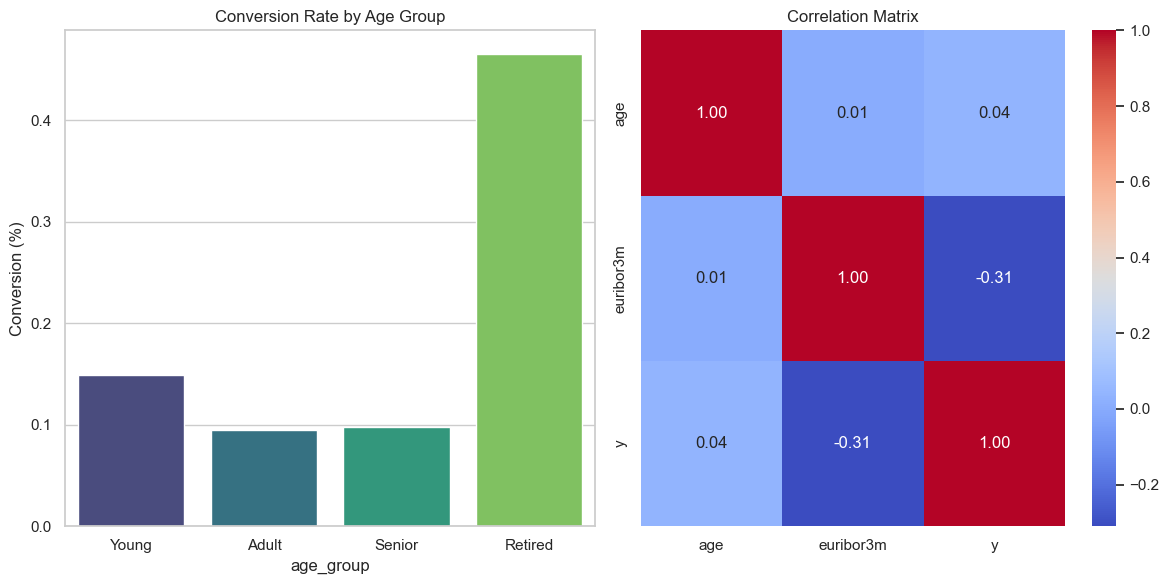

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración visual
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))

# 1. GRÁFICO DE BARRAS: Tasa de éxito por Grupo de Edad
plt.subplot(1, 2, 1)
sns.barplot(data=df_final, x='age_group', y='y', hue='age_group', palette='viridis', errorbar=None, legend=False)
plt.title('Conversion Rate by Age Group')
plt.ylabel('Conversion (%)')

# 2. GRÁFICO DE CALOR (Heatmap): Correlación
col_eur_real = [c for c in df_final.columns if 'euribor' in c][0]
cols_interes = ['age', col_eur_real, 'y'] 

plt.subplot(1, 2, 2)
sns.heatmap(df_final[cols_interes].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')

plt.tight_layout()
plt.show()

## ALGUNAS OBSERVACIONES

El GRAFICO DE BARRAS muestra que el grupo Retired tiene una tasa de conversión altísima (casi el 50%) comparado con los demás grupos que no llegan al 15%.

Por lo tanto podriamos recomendar centrar las campañas telefónicas en el sector Senior/Retired, ya que su efectividad es casi 4 veces superior".

La Correlación del Euribor: Hay un -0.31 entre el euribor3m y la y.

Por lo tanto existe una correlación negativa moderada; cuando el Euribor sube, la predisposición del cliente a contratar el producto disminuye".

In [8]:
# --- GUARDADO DEL DATASET FINAL ---

# 1. Definimos el nombre del archivo (con extensión .csv)
file_name = "bank_marketing_final_cleaned.csv"

# 2. Exportamos el DataFrame a CSV
# index=False para evita que se cree una columna extra de números (índices) al principio
df_final.to_csv(file_name, index=False)

print(f"✅ ¡Archivo guardado con éxito como: {file_name}!")
print(f"📊 Total de filas exportadas: {df_final.shape[0]}")
print(f"📋 Total de columnas: {df_final.shape[1]}")

✅ ¡Archivo guardado con éxito como: bank_marketing_final_cleaned.csv!
📊 Total de filas exportadas: 50100
📋 Total de columnas: 15
